# Table of Contents
1 - [Problem Statement](#ps)  
2 - [Overview of Dataset](#dataset)  
3 - [Loading the Data](#load)   
4 - [Exploratory Data Analysis](#eda)   
&emsp;  4.1 - [Data Cleaning: Deduplication](#deduplication)   
5 - [Text Preprocessing Using NLTK](#textprep)  
6 - [Train and Test Split of Data](#split)  
7 - [KNN Classification and Accuracy](#knn)  
&emsp;  7.1 - [Function to find the optimal k and error using 10-fold cross-validation](#bestk)  
&emsp;  7.2 - [Function to find the Accuracy and plot Confusion Matrix on TestData](#acc)  
&emsp;  7.3 - [Bag Of Words(unigram)](#bowuni)   
&emsp;  7.4 - [Bag Of Words(bigram)](#bowbi)  
&emsp;  7.5 - [TF-IDF(unigram)](#tfidfuni)  
&emsp;  7.6 - [TF-IDF(bigram)](#tfidfbi)    
&emsp;  7.7 - [Average Word2Vec](#avgw2v)  
&emsp;  7.8 - [TF-IDF Weighted Word2Vec](#tfidfw2v)  
8 - [Conclusion](#conclusion)

## [1] Problem Statement : <a name="ps"></a>

-  Time Based slicing to split Train Data(70%) and Test Data(30%)
-  Appling KNN model to find the optimal k(both brute Force and kd tree) and using 10 fold Cross Validation in :  
&emsp; 1)Bag Of Words  
&emsp; 2)TF-IDF  
&emsp; 3)Average Word2Vec  
&emsp; 4)TF-IDF Weighted Word2Vec  
-  Run Time Complexity Comparsion between Brute Force and kd Tree
-  Using Performance metric as "Accuracy" and comparing the Test Accuracies obtained by 4 featurization techniques.

## [2] Overview of Dataset : <a name="dataset"></a>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.  

Number of reviews: 568,454  
Number of users: 256,059  
Number of products: 74,258  
Timespan: Oct 1999 - Oct 2012  
Number of Attributes/Columns in data: 10  

Attribute Information:

&emsp;1.Id  
&emsp;2.ProductId - unique identifier for the product  
&emsp;3.UserId - unqiue identifier for the user  
&emsp;4.ProfileName  
&emsp;5.HelpfulnessNumerator - number of users who found the review helpful  
&emsp;6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not  
&emsp;7.Score - rating between 1 and 5  
&emsp;8.Time - timestamp for the review  
&emsp;9.Summary - brief summary of the review  
&emsp;10.Text - text of the review  

Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## [3] Loading the Data : <a name="load"></a>

In order to load the data, we have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
#Importing the necessary Packages
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import time
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import HTML
from collections import OrderedDict


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [2]:
import pickle

#dumping an object to file object using dump method
def dumpfile(a,file_Name):
    fileObject = open(file_Name,"wb")
    pickle.dump(a,fileObject,protocol=2)
    fileObject.close()

#loading an object from file object using load method
def loadfile(file_Name):
    fileObject = open(file_Name,"rb")
    b = pickle.load(fileObject)
    return b


In [1]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 2px  black solid !important;
}
</style>

In [4]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 


#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [5]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [6]:
print("Number of datapoints: ",filtered_data.shape[0])
print("Number of attributes/features: ",filtered_data.shape[1])
HTML(filtered_data.head().to_html(index=False))

Number of datapoints:  525814
Number of attributes/features:  10


Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## [4] Exploratory Data Analysis :<a name="eda"></a>

### [4.1] Data Cleaning: Deduplication <a name="deduplication"></a>
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

<b>Deduplication 1:-</b> As can be seen below the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

<b>Deduplication 2:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

(364171, 10)


<b>Deduplication 3:-</b> It was also seen that a same user has given different reviews for a same product at same time.I think it is normal for a user to give multiple reviews about a product,but that should be in diffrent time.<br>
So,all those rows with same user giving multiple reviews for a same product at same time are considered as duplicate and hence dropped.

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId= "A8891HVRDJAM6" 
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
86221,B000084E6V,A8891HVRDJAM6,"Marfaux ""Marfaux""",33,33,5,1161388800,Dog LOVE these!,We purchase these dinosaurs constantly. For s...
86236,B000084E6V,A8891HVRDJAM6,"Marfaux ""Marfaux""",3,3,5,1161388800,Very entertaining!,These dinos are great for powerful chewers! Ou...


In [13]:
final=final.drop_duplicates(subset={"ProductId","UserId","ProfileName","Time"}, keep='first', inplace=False)
print(final.shape)

(363633, 10)


<b>Deduplication 4:-</b> It was also seen that in few rows with Ids from 150493 to 150529 contain reviews regarding books,not fine foods.So I think these should be also removed from the dataset.
After looking at the productid column, it can be noticed that all the observations for fine foods start with B followed by numbers except for Ids from 150493 to 150529. 
I suppose the reviews for book ‘Chicken soup for the soul’ have gotten into the datset mistakenly as they contain the words “chicken soup.

In [14]:
display = final[final.ProductId == "0006641040"]
HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [15]:
final = final[final.ProductId != "0006641040"]

In [16]:
print("Percentage  of data still remaining : ",(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

#Before starting the next phase of preprocessing lets see the number of entries left
print("Number of reviews left after Data Cleaning and Deduplication :")
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

Percentage  of data still remaining :  69.14973735959865
Number of reviews left after Data Cleaning and Deduplication :
(363599, 10)


positive    306566
negative     57033
Name: Score, dtype: int64

<b>Observation:-</b>  
It is an imbalanced dataset as the number of positive reviews are way high in number than negative reviews.

## [5] Text Preprocessing Using NLTK : <a name="textprep"></a>

In the Preprocessing phase we do the following in the order below:-

1. Removal of HTML Tags
2. Removal of  any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Removal of  Stopwords
7. Finally Snowball Stemming the word <br>

After which we collect the words used to describe positive and negative reviews

In [20]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

10
I wanted a treat that was accepted and well liked for my rescue animals.<br />This is the only treat that is healthy and loved by all 4 legged beings in my home!<br />It does not contain sugar or grains or silly vegetables which virtually all treats contain. Dogs, cats and ferrets are carnivores they are not cattle to eat grain or rabbits to eat vegetables, and WHYYYY do companies add sugar,beet pulp or corn syrup to carnivore foods? It is dangerous and can cause the death of an animal with diabetes.<br />It is pretty easy to break into smaller pieces for cats and kittens with weak jaws and its wonderful to use as an aid to gain the trust of an abused dog as it will not cause stomach upset when given in common sense amounts.<br />I like that it goes a long way as it costs alot to heal and maintain and train abused and rescued dogs.<br />NO minus to this product other then the price,I can not afford to use it as much as I would like.


### [5.1] Removal of html Tags :

In [21]:
#function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

cleanhtml("<br />This is the only treat that is healthy and loved by all 4 legged beings in my home!<br />It does not contain sugar or grains")

' This is the only treat that is healthy and loved by all 4 legged beings in my home! It does not contain sugar or grains'

### [5.2] Removal of Punctuations and unecessary characters :

In [22]:
#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#|@|~|%|*]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

cleanpunc("WHYYYY do companies add sugar,beet pulp or corn syrup to carnivore foods?")

'WHYYYY do companies add sugar beet pulp or corn syrup to carnivore foods'

### [5.3] StopWords :

In [23]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
  
stop = set(stopwords.words('english')) #set of stopwords
print(stop)
print("*********************************************************************")
print("No. of stop words: ",len(stop))

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'further', 'should', 'didn', 'them', 'me', "hasn't", 'as', 'ma', 'itself', 'then', 'whom', "weren't", 'has', 'from', 're', 'while', "don't", 'aren', "haven't", 'but', 'such', 'very', "didn't", 'nor', 'so', 'being', "shan't", 'most', 'only', 'hadn', 'ourselves', 'because', 'what', 'were', "isn't", 'the', 'shouldn', "should've", 'own', "wouldn't", 'down', 'couldn', 'can', 'during', 'mightn', 'against', "wasn't", 'up', "hadn't", 'for', 'other', 'hasn', 'myself', 'how', 'theirs', 'did', 'at', 'or', 'do', 't', 'just', 'which', "mightn't", "that'll", 'if', 'we', 'this', 'after', 'now', "mustn't", "it's", 'they', 'than', 'hers', 'his', 'through', 'weren', 'ain', 'their', 'out', 'shan', 'won', 'all', 'had', 'are', 'those', 'above', "you've", 'ours', 'be

In [24]:
exceptions = ["aren't","mightn","wasn","hadn","don't","against","hadn't","shan","weren't","didn","don","hasn't", \
              "hasn","shouldn","didn't","wouldn","wasn't","needn't","shouldn't","wouldn't","aren","isn't","doesn't", \
              "nor","not","needn","couldn't","mightn't","mustn","mustn't","ain","shan't","haven","won't","couldn","isn", \
              "weren","haven't","no","haven't"]
new_stop = []
for i in stop:
    if i not in exceptions:
        new_stop.append(i)


print("No. of stop words after removing exceptions: ",len(new_stop))

No. of stop words after removing exceptions:  140


### [5.4] Stemming :

In [25]:
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

print("Orginal word: beautiful" + "|" +  "Stem word: " + sno.stem('beautiful'))
print("Orginal word: beauty" + "|" +  "Stem word: " + sno.stem('beauty'))
print("Orginal word: loved" + "|" +  "Stem word: " + sno.stem('loved'))
print("Orginal word: loving" + "|" +  "Stem word: " + sno.stem('loving'))

Orginal word: beautiful|Stem word: beauti
Orginal word: beauty|Stem word: beauti
Orginal word: loved|Stem word: love
Orginal word: loving|Stem word: love


<b>Observation:-</b>  
We can see words like "beautiful" and "beauty" have their stem as "beauti","loved" and "loving" have their stem as "love".  
Hence it helps in reducing the dimensions by taking the root stem of words.

### [5.5] Implementing the preprocessing steps one by one on all the<br>reviews of dataset :

In [22]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in new_stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [23]:
from nltk.probability import FreqDist
pdist = FreqDist(all_positive_words)
top_positive = pdist.most_common(20)
print("Top 20 Positive words ocuring frequenty in reviews:")
top_positive

Top 20 Positive words ocuring frequenty in reviews:


[(b'not', 146568),
 (b'like', 139160),
 (b'tast', 128865),
 (b'good', 112601),
 (b'flavor', 109329),
 (b'love', 107172),
 (b'use', 103792),
 (b'great', 103670),
 (b'one', 96529),
 (b'product', 90912),
 (b'tri', 86683),
 (b'tea', 83699),
 (b'coffe', 78763),
 (b'make', 75004),
 (b'get', 71996),
 (b'food', 64539),
 (b'would', 55477),
 (b'time', 55184),
 (b'buy', 54137),
 (b'realli', 52657)]

In [24]:
ndist = FreqDist(all_negative_words)
top_negative = ndist.most_common(20)
print("Top 20 Negative words ocuring frequenty in reviews:")
top_negative

Top 20 Negative words ocuring frequenty in reviews:


[(b'not', 54325),
 (b'tast', 34534),
 (b'like', 32271),
 (b'product', 28181),
 (b'one', 20544),
 (b'flavor', 19520),
 (b'would', 17947),
 (b'tri', 17718),
 (b'use', 15280),
 (b'good', 15024),
 (b'coffe', 14700),
 (b'get', 13775),
 (b'buy', 13742),
 (b'order', 12862),
 (b'food', 12720),
 (b'dont', 11865),
 (b'tea', 11646),
 (b'even', 11068),
 (b'box', 10833),
 (b'amazon', 10067)]

### [5.6] Adding a new column of CleanedText which displays the data after<br>pre-processing of the review  :

In [27]:
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [26]:
final[['Text','CleanedText']].head(10)

,Text,CleanedText
476617,This product by Arche...,product archer farm b...
22621,Our dogs just love th...,dog love saw pet stor...
22620,My dogs loves this ch...,dog love chicken prod...
284375,This book is easy to ...,book easi read ingred...
157850,I have been feeding m...,feed greyhound treat ...
157849,This is one product t...,one product welsh ter...
157833,This is the ONLY dog ...,dog treat lhasa apso ...
157832,These liver treas are...,liver trea phenomen r...
157837,This was the only tre...,treat dog like obedi ...
157831,"No waste , even if sh...",wast even day goe hun...


### [5.7] Using SQLite Table to load data after preprocessing <br> of reviews  :

In [ ]:
# store final result into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [4]:
# using the SQLite Table to read data.
conn = sqlite3.connect('final.sqlite') 

final = pd.read_sql_query(""" SELECT * FROM Reviews """,conn) 

In [5]:
#Listing out the number of positive and negative reviews
final = final.reset_index(drop=True)
final['Score'].value_counts()

positive    306566
negative     57033
Name: Score, dtype: int64

In [6]:
(final['Score'].value_counts()/len(final['Score']))*100

positive    84.314313
negative    15.685687
Name: Score, dtype: float64

### [5.7] Sampling 100k Reviews(same ratio as present in orginal dataset) from the dataset:

In [7]:
n_samples = 100000
sample_data = final.sample(n = n_samples)
print("Shape of the Sampled Data: ",sample_data.shape)
print("Percentage of reviews:\n",(final['Score'].value_counts()/len(final['Score']))*100)

Shape of the Sampled Data:  (100000, 12)
Percentage of reviews:
 positive    84.314313
negative    15.685687
Name: Score, dtype: float64


## [6] Train and Test Split of Data : <a name="split"></a>

<b>Sorting the data by Time :</b>

In [8]:
sample_data=sample_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sample_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
179,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...
225,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
288,346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,get crazi look beatlejuic french version video...
205,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
213,346115,374421,B00004CI84,A1FJOY14X3MUHE,Justin Howard,2,2,positive,966297600,"A fresh, original film from master storyteller...","This is such a great film, I don't even know h...",great film dont even know sum first complet or...


<b>Time Based Slicing :</b>  
-  Diving the data to Train set(first 70% ie older data) and Test  Set(last 30% ie recent data)

In [9]:
from sklearn.model_selection import train_test_split

X = sample_data["CleanedText"].values
y = sample_data["Score"].values
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,shuffle = False)

In [7]:
print("Shape of X_train: ",X_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of y_test: ",y_test.shape)

Shape of X_train:  (70000,)
Shape of y_train:  (70000,)
Shape of X_test:  (30000,)
Shape of y_test:  (30000,)


In [11]:
dumpfile(X,"X")
dumpfile(y,"y") 
dumpfile(X_train,"X_train")
dumpfile(y_train,"y_train")
dumpfile(X_test,"X_test")
dumpfile(y_test,"y_test")

In [18]:
X = loadfile("X")
y = loadfile("y")
X_train = loadfile("X_train")
y_train = loadfile("y_train")
X_test = loadfile("X_test")
y_test = loadfile("y_test")

## [7] KNN Classification and Accuracy : <a name="knn"></a>

### [7.1] Function to find the optimal k and error using K-fold cross-validation : <a name="bestk"></a>
-  Taking odd number of neighbors between range 1 and 30  
-  TimeSeries Split and performing K fold cross validation on Train Data  
-  Finding the optimal k  
-  Plotting between cv error/cv Accuracy and Number of Neighbors

In [19]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score as cv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

myList = list(range(0,30))
n_neighbors = list(filter(lambda x: x % 2 != 0,myList)) #taking a list of odd nearest neighbours to win a clear majority vote

def KNeighbors(X_train,y_train,algo,cr_val):
    
    #Cross validation using TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=cr_val)
    split = 1

    for train_index, cv_index in tscv.split(X_train):
        print("\n\033[1mSplit {} ---------->\033[0m".format(split))
        X_tr, X_cv = X_train[train_index], X_train[cv_index]
        print("Shape of Train Data: ",X_tr.shape)
        print("Shape of CV Data: ",X_cv.shape)
        split = split + 1
        
    cv_scores = []
    
    for k in n_neighbors:
        model = KNeighborsClassifier(n_neighbors = k, weights = "distance", algorithm = algo)
        scores = cv(estimator = model, X = X_train, y = y_train, cv = tscv, scoring = "accuracy")
        cv_scores.append(scores.mean())
    
    #Misclassification error
    MSE = [1 - x for x in cv_scores]
    #Finding the optimal K
    optimal_k = n_neighbors[MSE.index(min(MSE))]
    
    best_accuracy = np.round(max(cv_scores) * 100,3)
    
    print("\n\033[1mThe optimal number of neighbors:\033[0m ", optimal_k)
    print("\n\033[1mCrossValidation Error:\033[0m {}".format(np.round(min(MSE),3)))
    print("\n\033[1mCrossValidation Accuracy:\033[0m {} %".format(best_accuracy))
    
    plt.figure(figsize=(20,6))
    plt.subplot(121)
    plt.plot(n_neighbors,MSE, 'b--o')
    for xy in zip(n_neighbors, np.round(MSE,3)):
        plt.annotate('(%s %s)' % xy, xy = xy, textcoords = 'data')
    plt.title("CV Error vs Neighbors")
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("CV Error")

    plt.subplot(122)
    plt.plot(n_neighbors,cv_scores, 'r--o')
    for xy in zip(n_neighbors, np.round(cv_scores,3)):
        plt.annotate('(%s %s)' % xy, xy = xy, textcoords = 'data')
    plt.title("CV Accuracy vs Neighbors")
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("CV Accuracy")
    plt.show()
    
    print("\n\033[1mCV Error for each value of k:\033[0m ",np.round(MSE,3))
    print("\n\033[1mCV Accuracy for each value of k:\033[0m ",np.round(cv_scores,3))
    
    return np.round(min(MSE),3)

### [7.2] Function to find the Accuracy and plot Confusion Matrix on TestData : <a name="acc"></a>
-  Finding the Test Accuracy on optimal k  
-  Plotting the Confusion matrix

In [20]:
def KNeighbors_Test(X_train,X_test,y_train,y_test,algo,optimal_k,batchwise_points = 15000):
    
    optimal_model = KNeighborsClassifier(n_neighbors = optimal_k, weights = "distance", algorithm = algo)
    optimal_model.fit(X_train, y_train)
    
    y_pred1 = optimal_model.predict(X_test[0:batchwise_points,:])
    correct1 = accuracy_score(y_test[:batchwise_points],y_pred1) * batchwise_points
    y_pred2 = optimal_model.predict(X_test[batchwise_points:,:])
    correct2 = accuracy_score(y_test[batchwise_points:],y_pred2) * batchwise_points

   
    
    y_pred = np.concatenate((y_pred1, y_pred2), axis=0)
    
    accuracy = accuracy_score(y_test,y_pred) * 100
    MSE = (1 - (accuracy/100))
    print("\n\033[1mTest Accuracy with {} Neighbors:\033[0m {} %".format(optimal_k,np.round(accuracy,3)))
    print("\n\033[1mTest Error :\033[0m {}".format(np.round(MSE,3)))
    
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm,
                     index = ['negative','positive'], 
                     columns = ['negative','positive'])
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(cm)
    
    return np.round(MSE,3),np.round(accuracy,3)

### [7.3] Bag Of Words(unigram) : <a name="bowuni"></a>

<b>Taking min_df = 0.0005 to ignore terms that appear in less than 0.05% of the documents(do not occur too frequently)</b>

In [23]:
%%time
bow_unigram = CountVectorizer(min_df = 0.0005)
X_train_bowuni = bow_unigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_bowuni))
print("The shape of text BOW vectorizer: ", X_train_bowuni.get_shape())
print("Number of unique word: ", X_train_bowuni.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text BOW vectorizer:  (70000, 3914)
Number of unique word:  3914
CPU times: user 3.22 s, sys: 12 ms, total: 3.24 s
Wall time: 3.24 s


In [24]:
%%time
X_test_bowuni = bow_unigram.transform(X_test)
print("The shape of text BOW vectorizer: ", X_test_bowuni.get_shape())
print("Number of unique word: ", X_test_bowuni.get_shape()[1])

The shape of text BOW vectorizer:  (30000, 3914)
Number of unique word:  3914
CPU times: user 1.51 s, sys: 0 ns, total: 1.51 s
Wall time: 1.5 s


In [25]:
dumpfile(X_train_bowuni,"X_train_bowuni")
dumpfile(X_test_bowuni,"X_test_bowuni")

In [10]:
X_train_bowuni = loadfile("X_train_bowuni")
X_test_bowuni = loadfile("X_test_bowuni")

#### [7.3.1] KNN Using Brute Force Algorithim :

In [27]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_bowuni_std = sc.fit_transform(X_train_bowuni)

In [28]:
X_test_bowuni_std = sc.transform(X_test_bowuni)

In [29]:
print("Shape of Training Data: ",X_train_bowuni_std.shape)
print("Shape of Test Data: ",X_test_bowuni_std.shape)

Shape of Training Data:  (70000, 3914)
Shape of Test Data:  (30000, 3914)



Split 1 ---------->
Shape of Train Data:  (6370, 3914)
Shape of CV Data:  (6363, 3914)

Split 2 ---------->
Shape of Train Data:  (12733, 3914)
Shape of CV Data:  (6363, 3914)

Split 3 ---------->
Shape of Train Data:  (19096, 3914)
Shape of CV Data:  (6363, 3914)

Split 4 ---------->
Shape of Train Data:  (25459, 3914)
Shape of CV Data:  (6363, 3914)

Split 5 ---------->
Shape of Train Data:  (31822, 3914)
Shape of CV Data:  (6363, 3914)

Split 6 ---------->
Shape of Train Data:  (38185, 3914)
Shape of CV Data:  (6363, 3914)

Split 7 ---------->
Shape of Train Data:  (44548, 3914)
Shape of CV Data:  (6363, 3914)

Split 8 ---------->
Shape of Train Data:  (50911, 3914)
Shape of CV Data:  (6363, 3914)

Split 9 ---------->
Shape of Train Data:  (57274, 3914)
Shape of CV Data:  (6363, 3914)

Split 10 ---------->
Shape of Train Data:  (63637, 3914)
Shape of CV Data:  (6363, 3914)

The optimal number of neighbors:  7

CrossValidation Error: 0.148

CrossValidation Accuracy: 85.194 %


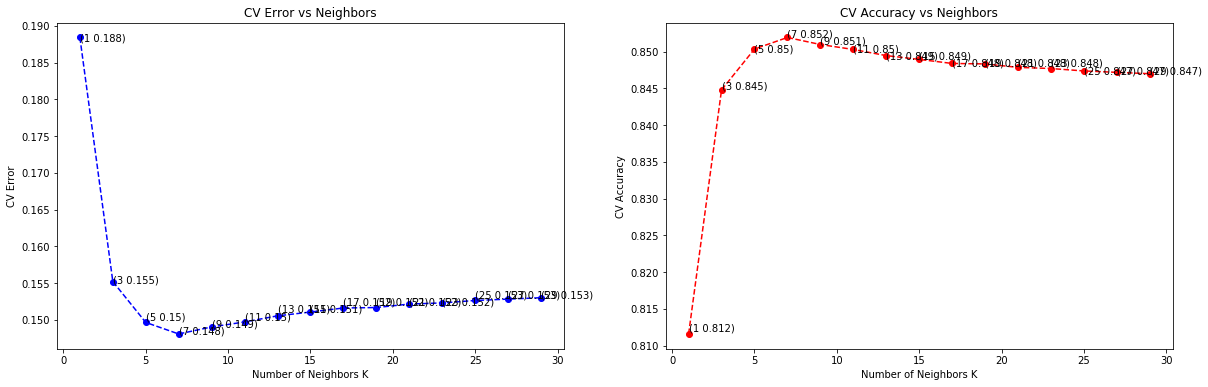


CV Error for each value of k:  [0.188 0.155 0.15  0.148 0.149 0.15  0.151 0.151 0.152 0.152 0.152 0.152
 0.153 0.153 0.153]

CV Accuracy for each value of k:  [0.812 0.845 0.85  0.852 0.851 0.85  0.849 0.849 0.848 0.848 0.848 0.848
 0.847 0.847 0.847]
CPU times: user 26min 40s, sys: 1min 54s, total: 28min 35s
Wall time: 28min 35s


In [30]:
%%time
if __name__ == "__main__":
    KNeighbors(X_train_bowuni_std, y_train, "brute", cr_val=10)


Test Accuracy with 7 Neighbors: 83.347 %

Test Error : 0.167


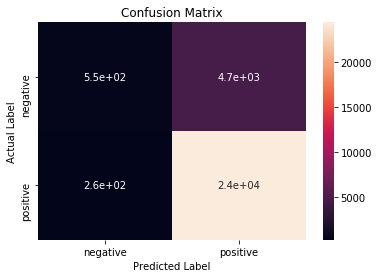

[[  546  4731]
 [  265 24458]]
CPU times: user 1min 45s, sys: 7.69 s, total: 1min 53s
Wall time: 1min 53s


In [32]:
%%time
if __name__ == "__main__":
    KNeighbors_Test(X_train_bowuni_std, X_test_bowuni_std, y_train, y_test, "brute", optimal_k = 7, batchwise_points = 15000)

#### [7.3.2] KNN Using Kd_Tree Algorithim :  
<b>Reducing the dimensions(d = 50) using Truncated SVD and finding the optimal k using 10-fold cross validation. </b>

In [11]:
%%time
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=50,n_iter=5,random_state=0)
X_train_bowuni_kdtree = tsvd.fit_transform(X_train_bowuni)
X_test_bowuni_kdtree = tsvd.transform(X_test_bowuni)

CPU times: user 23.7 s, sys: 1.19 s, total: 24.9 s
Wall time: 6.5 s


In [12]:
dumpfile(X_train_bowuni_kdtree,"X_train_bowuni_kdtree")
dumpfile(X_test_bowuni_kdtree,"X_test_bowuni_kdtree")

In [13]:
X_train_bowuni_kdtree = loadfile("X_train_bowuni_kdtree")
X_test_bowuni_kdtree = loadfile("X_test_bowuni_kdtree")

In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_bowuni_kdtree_std = sc.fit_transform(X_train_bowuni_kdtree)

In [15]:
X_test_bowuni_kdtree_std = sc.transform(X_test_bowuni_kdtree)

In [16]:
print("Shape of Training Data: ",X_train_bowuni_kdtree_std.shape)
print("Shape of Test Data: ",X_test_bowuni_kdtree_std.shape)

Shape of Training Data:  (70000, 50)
Shape of Test Data:  (30000, 50)



Split 1 ---------->
Shape of Train Data:  (6370, 50)
Shape of CV Data:  (6363, 50)

Split 2 ---------->
Shape of Train Data:  (12733, 50)
Shape of CV Data:  (6363, 50)

Split 3 ---------->
Shape of Train Data:  (19096, 50)
Shape of CV Data:  (6363, 50)

Split 4 ---------->
Shape of Train Data:  (25459, 50)
Shape of CV Data:  (6363, 50)

Split 5 ---------->
Shape of Train Data:  (31822, 50)
Shape of CV Data:  (6363, 50)

Split 6 ---------->
Shape of Train Data:  (38185, 50)
Shape of CV Data:  (6363, 50)

Split 7 ---------->
Shape of Train Data:  (44548, 50)
Shape of CV Data:  (6363, 50)

Split 8 ---------->
Shape of Train Data:  (50911, 50)
Shape of CV Data:  (6363, 50)

Split 9 ---------->
Shape of Train Data:  (57274, 50)
Shape of CV Data:  (6363, 50)

Split 10 ---------->
Shape of Train Data:  (63637, 50)
Shape of CV Data:  (6363, 50)

The optimal number of neighbors:  11

CrossValidation Error: 0.147

CrossValidation Accuracy: 85.299 %


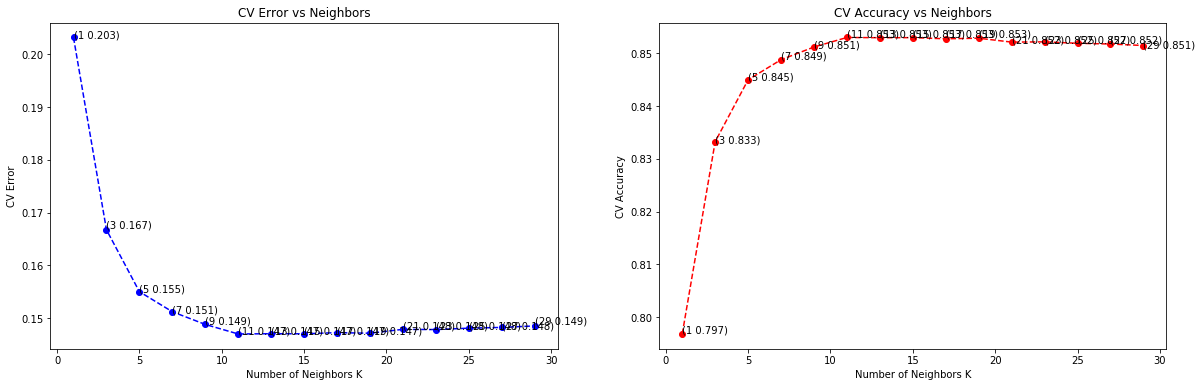


CV Error for each value of k:  [0.203 0.167 0.155 0.151 0.149 0.147 0.147 0.147 0.147 0.147 0.148 0.148
 0.148 0.148 0.149]

CV Accuracy for each value of k:  [0.797 0.833 0.845 0.849 0.851 0.853 0.853 0.853 0.853 0.853 0.852 0.852
 0.852 0.852 0.851]
CPU times: user 1h 43min 52s, sys: 124 ms, total: 1h 43min 52s
Wall time: 1h 43min 53s


In [ ]:
%%time
if __name__ == "__main__":
    KNeighbors(X_train_bowuni_kdtree_std, y_train, "kd_tree",cr_val=10)


Test Accuracy with 11 Neighbors: 83.733 %

Test Error : 0.163


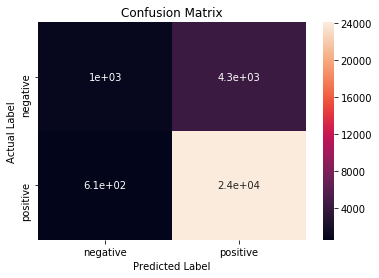

[[ 1006  4271]
 [  609 24114]]
CPU times: user 7min 30s, sys: 16 ms, total: 7min 30s
Wall time: 7min 30s


In [ ]:
%%time
if __name__ == "__main__":
    KNeighbors_Test(X_train_bowuni_kdtree_std, X_test_bowuni_kdtree_std, y_train, y_test, "kd_tree", optimal_k = 11, batchwise_points = 15000)

 

<b>Observations</b>:  

| KNN Algorithim | Optimal K | CV Error | Test Error | Test Accuracy(In %) |
| --- | --- | --- | --- | --- |
| Brute Force | 7 | 0.148 | 0.167 | 83.347 |
| Kd Tree | 11 | 0.147 | 0.163 | 84.733|

### [7.4] Bag Of Words(bigram) : <a name="bowbi"></a>

<b>Taking min_df = 0.0005 to ignore terms that appear in less than 0.05% of the documents(do not occur too frequently)</b>

In [8]:
%%time
bow_bigram = CountVectorizer(min_df = 0.0005, ngram_range=(1, 2))
X_train_bowbi = bow_bigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_bowbi))
print("The shape of text BOW vectorizer: ", X_train_bowbi.get_shape())
print("Number of unique word: ", X_train_bowbi.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text BOW vectorizer:  (70000, 10979)
Number of unique word:  10979
CPU times: user 10.5 s, sys: 88 ms, total: 10.6 s
Wall time: 10.6 s


In [9]:
%%time
X_test_bowbi = bow_bigram.transform(X_test)
print("The shape of text BOW vectorizer: ", X_test_bowbi.get_shape())
print("Number of unique word: ", X_test_bowbi.get_shape()[1])

The shape of text BOW vectorizer:  (30000, 10979)
Number of unique word:  10979
CPU times: user 2.92 s, sys: 0 ns, total: 2.92 s
Wall time: 2.92 s


In [11]:
dumpfile(X_train_bowbi,"X_train_bowbi")
dumpfile(X_test_bowbi,"X_test_bowbi")

In [7]:
X_train_bowbi = loadfile("X_train_bowbi")
X_test_bowbi = loadfile("X_test_bowbi")

#### [7.4.1] KNN Using Brute Force Algorithim :

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_bowbi_std = sc.fit_transform(X_train_bowbi)

In [11]:
X_test_bowbi_std = sc.transform(X_test_bowbi)

In [12]:
print("Shape of Training Data: ",X_train_bowbi_std.shape)
print("Shape of Test Data: ",X_test_bowbi_std.shape)

Shape of Training Data:  (70000, 10979)
Shape of Test Data:  (30000, 10979)



Split 1 ---------->
Shape of Train Data:  (6370, 10979)
Shape of CV Data:  (6363, 10979)

Split 2 ---------->
Shape of Train Data:  (12733, 10979)
Shape of CV Data:  (6363, 10979)

Split 3 ---------->
Shape of Train Data:  (19096, 10979)
Shape of CV Data:  (6363, 10979)

Split 4 ---------->
Shape of Train Data:  (25459, 10979)
Shape of CV Data:  (6363, 10979)

Split 5 ---------->
Shape of Train Data:  (31822, 10979)
Shape of CV Data:  (6363, 10979)

Split 6 ---------->
Shape of Train Data:  (38185, 10979)
Shape of CV Data:  (6363, 10979)

Split 7 ---------->
Shape of Train Data:  (44548, 10979)
Shape of CV Data:  (6363, 10979)

Split 8 ---------->
Shape of Train Data:  (50911, 10979)
Shape of CV Data:  (6363, 10979)

Split 9 ---------->
Shape of Train Data:  (57274, 10979)
Shape of CV Data:  (6363, 10979)

Split 10 ---------->
Shape of Train Data:  (63637, 10979)
Shape of CV Data:  (6363, 10979)

The optimal number of neighbors:  9

CrossValidation Error: 0.15

CrossValidation Accurac

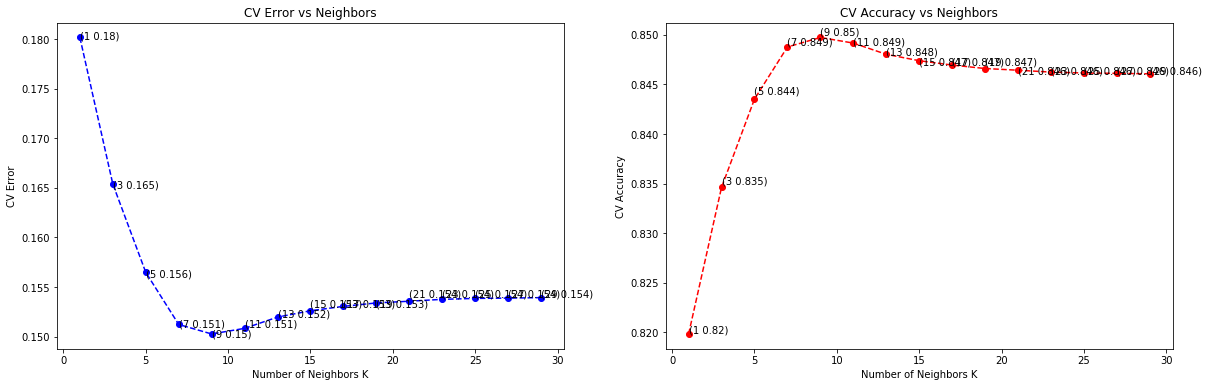


CV Error for each value of k:  [0.18  0.165 0.156 0.151 0.15  0.151 0.152 0.153 0.153 0.153 0.154 0.154
 0.154 0.154 0.154]

CV Accuracy for each value of k:  [0.82  0.835 0.844 0.849 0.85  0.849 0.848 0.847 0.847 0.847 0.846 0.846
 0.846 0.846 0.846]
CPU times: user 26min 17s, sys: 1min 50s, total: 28min 8s
Wall time: 28min 8s


In [ ]:
%%time
if __name__ == "__main__":
    KNeighbors(X_train_bowbi_std, y_train,"brute",cr_val = 10)


Test Accuracy with 9 Neighbors: 82.907 %

Test Error : 0.171


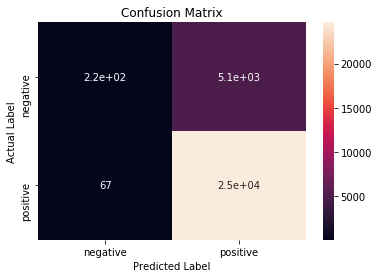

[[  216  5061]
 [   67 24656]]
CPU times: user 1min 47s, sys: 9.36 s, total: 1min 56s
Wall time: 1min 56s


In [13]:
%%time
if __name__ == "__main__":
    KNeighbors_Test(X_train_bowbi_std, X_test_bowbi_std, y_train, y_test, "brute", optimal_k = 9,batchwise_points = 15000)

#### [7.4.2] KNN Using Kd_Tree Algorithim :

<b>Reducing the dimensions(d = 50) using Truncated SVD and finding the optimal k using 10-fold cross validation. </b>

In [8]:
%%time
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=50,n_iter=5,random_state=0)
X_train_bowbi_kdtree = tsvd.fit_transform(X_train_bowbi)
X_test_bowbi_kdtree = tsvd.transform(X_test_bowbi)

CPU times: user 17.1 s, sys: 256 ms, total: 17.3 s
Wall time: 3.86 s


In [9]:
dumpfile(X_train_bowbi_kdtree,"X_train_bowbi_kdtree")
dumpfile(X_test_bowbi_kdtree,"X_test_bowbi_kdtree")

In [9]:
X_train_bowbi_kdtree = loadfile("X_train_bowbi_kdtree")
X_test_bowbi_kdtree = loadfile("X_test_bowbi_kdtree")

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_bowbi_kdtree_std = sc.fit_transform(X_train_bowbi_kdtree)

In [11]:
X_test_bowbi_kdtree_std = sc.transform(X_test_bowbi_kdtree)

In [12]:
print("Shape of Training Data: ",X_train_bowbi_kdtree_std.shape)
print("Shape of Test Data: ",X_test_bowbi_kdtree_std.shape)

Shape of Training Data:  (70000, 50)
Shape of Test Data:  (30000, 50)



Split 1 ---------->
Shape of Train Data:  (6370, 50)
Shape of CV Data:  (6363, 50)

Split 2 ---------->
Shape of Train Data:  (12733, 50)
Shape of CV Data:  (6363, 50)

Split 3 ---------->
Shape of Train Data:  (19096, 50)
Shape of CV Data:  (6363, 50)

Split 4 ---------->
Shape of Train Data:  (25459, 50)
Shape of CV Data:  (6363, 50)

Split 5 ---------->
Shape of Train Data:  (31822, 50)
Shape of CV Data:  (6363, 50)

Split 6 ---------->
Shape of Train Data:  (38185, 50)
Shape of CV Data:  (6363, 50)

Split 7 ---------->
Shape of Train Data:  (44548, 50)
Shape of CV Data:  (6363, 50)

Split 8 ---------->
Shape of Train Data:  (50911, 50)
Shape of CV Data:  (6363, 50)

Split 9 ---------->
Shape of Train Data:  (57274, 50)
Shape of CV Data:  (6363, 50)

Split 10 ---------->
Shape of Train Data:  (63637, 50)
Shape of CV Data:  (6363, 50)

The optimal number of neighbors:  17

CrossValidation Error: 0.147

CrossValidation Accuracy: 85.336 %


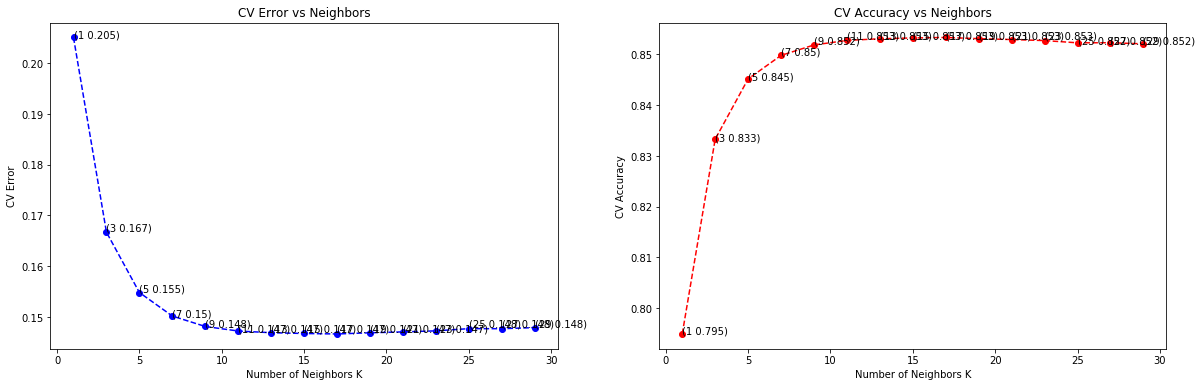


CV Error for each value of k:  [0.205 0.167 0.155 0.15  0.148 0.147 0.147 0.147 0.147 0.147 0.147 0.147
 0.148 0.148 0.148]

CV Accuracy for each value of k:  [0.795 0.833 0.845 0.85  0.852 0.853 0.853 0.853 0.853 0.853 0.853 0.853
 0.852 0.852 0.852]
CPU times: user 1h 44min 4s, sys: 56 ms, total: 1h 44min 4s
Wall time: 1h 44min 4s


In [ ]:
%%time
if __name__ == "__main__":
    KNeighbors(X_train_bowbi_kdtree_std, y_train, "kd_tree",cr_val = 10)


Test Accuracy with 17 Neighbors: 83.917 %

Test Error : 0.161


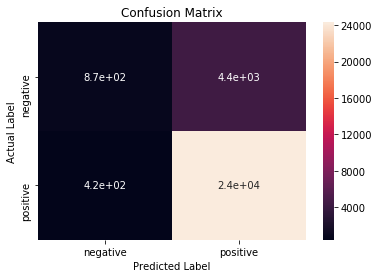

[[  869  4408]
 [  417 24306]]
CPU times: user 7min 46s, sys: 24 ms, total: 7min 46s
Wall time: 7min 46s


In [13]:
%%time
if __name__ == "__main__":
    KNeighbors_Test(X_train_bowbi_kdtree_std, X_test_bowbi_kdtree_std, y_train, y_test, "kd_tree", optimal_k = 17, batchwise_points = 15000)

 

<b>Observations</b>:  

| KNN Algorithim | Optimal K | CV Error | Test Error | Test Accuracy(In %) |
| --- | --- | --- | --- | --- |
| Brute Force | 9 | 0.15 | 0.171 | 82.907 |
| Kd Tree | 17 | 0.147 | 0.161 | 83.917|

### [7.5] TF-IDF(unigram) : <a name="tfidfuni"></a>

<b>Taking min_df = 0.0005 to ignore terms that appear in less than 0.05% of the documents(do not occur too frequently)</b>

In [14]:
%%time
tfidf_unigram = TfidfVectorizer(min_df = 0.0005)
X_train_tfidfuni = tfidf_unigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_tfidfuni))
print("The shape of text TFIDF vectorizer: ", X_train_tfidfuni.get_shape())
print("Number of unique word: ", X_train_tfidfuni.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text TFIDF vectorizer:  (70000, 3914)
Number of unique word:  3914
CPU times: user 3.27 s, sys: 0 ns, total: 3.27 s
Wall time: 3.27 s


In [15]:
%%time
X_test_tfidfuni = tfidf_unigram.transform(X_test)
print("The shape of text TFIDF vectorizer: ", X_test_tfidfuni.get_shape())
print("Number of unique word: ", X_test_tfidfuni.get_shape()[1])

The shape of text TFIDF vectorizer:  (30000, 3914)
Number of unique word:  3914
CPU times: user 1.55 s, sys: 0 ns, total: 1.55 s
Wall time: 1.55 s


In [16]:
dumpfile(X_train_tfidfuni,"X_train_tfidfuni")
dumpfile(X_test_tfidfuni,"X_test_tfidfuni")

In [16]:
X_train_tfidfuni = loadfile("X_train_tfidfuni")
X_test_tfidfuni = loadfile("X_test_tfidfuni")

#### [7.5.1] KNN Using Brute Force Algorithim :

In [18]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_tfidfuni_std = sc.fit_transform(X_train_tfidfuni)

In [19]:
X_test_tfidfuni_std = sc.transform(X_test_tfidfuni)

In [20]:
print("Shape of Training Data: ",X_train_tfidfuni_std.shape)
print("Shape of Test Data: ",X_test_tfidfuni_std.shape)

Shape of Training Data:  (70000, 3914)
Shape of Test Data:  (30000, 3914)



Split 1 ---------->
Shape of Train Data:  (6370, 3914)
Shape of CV Data:  (6363, 3914)

Split 2 ---------->
Shape of Train Data:  (12733, 3914)
Shape of CV Data:  (6363, 3914)

Split 3 ---------->
Shape of Train Data:  (19096, 3914)
Shape of CV Data:  (6363, 3914)

Split 4 ---------->
Shape of Train Data:  (25459, 3914)
Shape of CV Data:  (6363, 3914)

Split 5 ---------->
Shape of Train Data:  (31822, 3914)
Shape of CV Data:  (6363, 3914)

Split 6 ---------->
Shape of Train Data:  (38185, 3914)
Shape of CV Data:  (6363, 3914)

Split 7 ---------->
Shape of Train Data:  (44548, 3914)
Shape of CV Data:  (6363, 3914)

Split 8 ---------->
Shape of Train Data:  (50911, 3914)
Shape of CV Data:  (6363, 3914)

Split 9 ---------->
Shape of Train Data:  (57274, 3914)
Shape of CV Data:  (6363, 3914)

Split 10 ---------->
Shape of Train Data:  (63637, 3914)
Shape of CV Data:  (6363, 3914)

The optimal number of neighbors:  7

CrossValidation Error: 0.152

CrossValidation Accuracy: 84.801 %


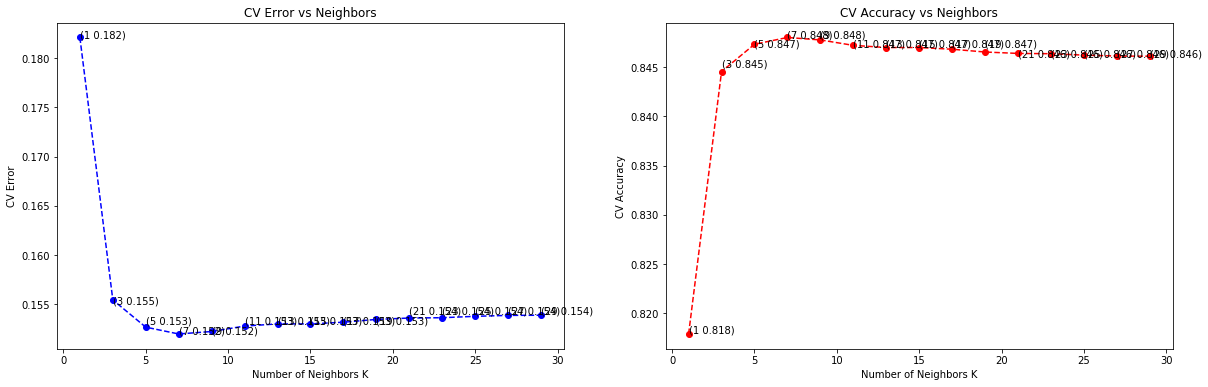


CV Error for each value of k:  [0.182 0.155 0.153 0.152 0.152 0.153 0.153 0.153 0.153 0.153 0.154 0.154
 0.154 0.154 0.154]

CV Accuracy for each value of k:  [0.818 0.845 0.847 0.848 0.848 0.847 0.847 0.847 0.847 0.847 0.846 0.846
 0.846 0.846 0.846]
CPU times: user 26min 41s, sys: 1min 44s, total: 28min 25s
Wall time: 28min 25s


In [21]:
%%time
if __name__ == "__main__":
    KNeighbors(X_train_tfidfuni_std, y_train, "brute", cr_val = 10)


Test Accuracy with 7 Neighbors: 82.753 %

Test Error : 0.172


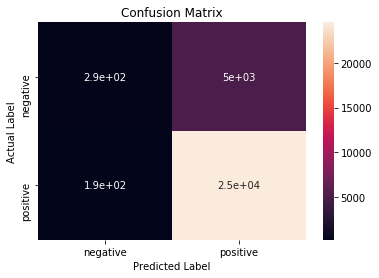

[[  289  4988]
 [  186 24537]]
CPU times: user 1min 42s, sys: 8.48 s, total: 1min 51s
Wall time: 1min 50s


In [22]:
%%time
if __name__ == "__main__":
    KNeighbors_Test(X_train_tfidfuni_std, X_test_tfidfuni_std, y_train, y_test, "brute", optimal_k = 7,  batchwise_points = 15000)

#### [7.5.2] KNN Using Kd_Tree Algorithim :

<b>Reducing the dimensions(d = 50) using Truncated SVD and finding the optimal k using 10-fold cross validation. </b>

In [17]:
%%time
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=50,n_iter=5,random_state=0)
X_train_tfidfuni_kdtree = tsvd.fit_transform(X_train_tfidfuni)
X_test_tfidfuni_kdtree = tsvd.transform(X_test_tfidfuni)

CPU times: user 12.4 s, sys: 224 ms, total: 12.6 s
Wall time: 2.71 s


In [18]:
dumpfile(X_train_tfidfuni_kdtree,"X_train_tfidfuni_kdtree")
dumpfile(X_test_tfidfuni_kdtree,"X_test_tfidfuni_kdtree")

In [19]:
X_train_tfidfuni_kdtree = loadfile("X_train_tfidfuni_kdtree")
X_test_tfidfuni_kdtree = loadfile("X_test_tfidfuni_kdtree")

In [20]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_tfidfuni_kdtree_std = sc.fit_transform(X_train_tfidfuni_kdtree)

In [21]:
X_test_tfidfuni_kdtree_std = sc.transform(X_test_tfidfuni_kdtree)

In [22]:
print("Shape of Training Data: ",X_train_tfidfuni_kdtree_std.shape)
print("Shape of Test Data: ",X_test_tfidfuni_kdtree_std.shape)

Shape of Training Data:  (70000, 50)
Shape of Test Data:  (30000, 50)



Split 1 ---------->
Shape of Train Data:  (6370, 50)
Shape of CV Data:  (6363, 50)

Split 2 ---------->
Shape of Train Data:  (12733, 50)
Shape of CV Data:  (6363, 50)

Split 3 ---------->
Shape of Train Data:  (19096, 50)
Shape of CV Data:  (6363, 50)

Split 4 ---------->
Shape of Train Data:  (25459, 50)
Shape of CV Data:  (6363, 50)

Split 5 ---------->
Shape of Train Data:  (31822, 50)
Shape of CV Data:  (6363, 50)

Split 6 ---------->
Shape of Train Data:  (38185, 50)
Shape of CV Data:  (6363, 50)

Split 7 ---------->
Shape of Train Data:  (44548, 50)
Shape of CV Data:  (6363, 50)

Split 8 ---------->
Shape of Train Data:  (50911, 50)
Shape of CV Data:  (6363, 50)

Split 9 ---------->
Shape of Train Data:  (57274, 50)
Shape of CV Data:  (6363, 50)

Split 10 ---------->
Shape of Train Data:  (63637, 50)
Shape of CV Data:  (6363, 50)

The optimal number of neighbors:  21

CrossValidation Error: 0.14

CrossValidation Accuracy: 86.036 %


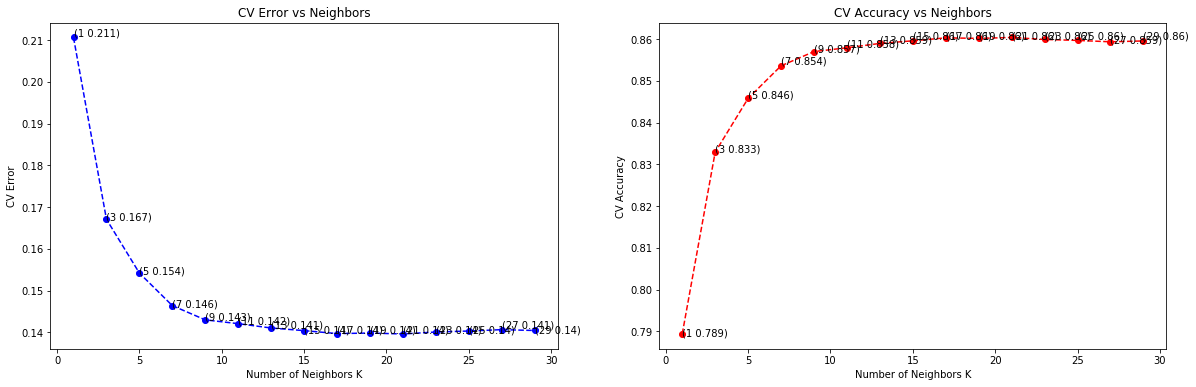


CV Error for each value of k:  [0.211 0.167 0.154 0.146 0.143 0.142 0.141 0.14  0.14  0.14  0.14  0.14
 0.14  0.141 0.14 ]

CV Accuracy for each value of k:  [0.789 0.833 0.846 0.854 0.857 0.858 0.859 0.86  0.86  0.86  0.86  0.86
 0.86  0.859 0.86 ]
CPU times: user 1h 45min 23s, sys: 92 ms, total: 1h 45min 23s
Wall time: 1h 45min 23s


In [23]:
%%time
if __name__ == "__main__":
    KNeighbors(X_train_tfidfuni_kdtree_std, y_train, "kd_tree",cr_val = 10)


Test Accuracy with 21 Neighbors: 84.79 %

Test Error : 0.152


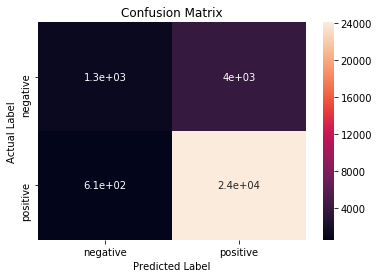

[[ 1322  3955]
 [  608 24115]]
CPU times: user 7min 37s, sys: 20 ms, total: 7min 37s
Wall time: 7min 36s


In [24]:
%%time
if __name__ == "__main__":
    KNeighbors_Test(X_train_tfidfuni_kdtree_std, X_test_tfidfuni_kdtree_std, y_train, y_test, "kd_tree", optimal_k = 21,  batchwise_points = 15000)

 

<b>Observations</b>:  

| KNN Algorithim | Optimal K | CV Error | Test Error | Test Accuracy(In %) |
| --- | --- | --- | --- | --- |
| Brute Force | 7 | 0.152 | 0.172 | 82.753 |
| Kd Tree | 21 | 0.14 | 0.152 | 84.79|

### [7.6] TF-IDF(bigram) : <a name="tfidfbi"></a>

<b>Taking min_df = 0.0005 to ignore terms that appear in less than 0.05% of the documents(do not occur too frequently)</b>

In [12]:
%%time
tfidf_bigram = TfidfVectorizer(min_df = 0.0005,ngram_range=(1, 2))
X_train_tfidfbi = tfidf_bigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_tfidfbi))
print("The shape of text TFIDF vectorizer: ", X_train_tfidfbi.get_shape())
print("Number of unique word: ", X_train_tfidfbi.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text TFIDF vectorizer:  (70000, 10979)
Number of unique word:  10979
CPU times: user 10.9 s, sys: 108 ms, total: 11 s
Wall time: 11 s


In [13]:
%%time
X_test_tfidfbi = tfidf_bigram.transform(X_test)
print("The shape of text TFIDF vectorizer: ", X_test_tfidfbi.get_shape())
print("Number of unique word: ", X_test_tfidfbi.get_shape()[1])

The shape of text TFIDF vectorizer:  (30000, 10979)
Number of unique word:  10979
CPU times: user 2.96 s, sys: 0 ns, total: 2.96 s
Wall time: 2.97 s


In [14]:
dumpfile(X_train_tfidfbi,"X_train_tfidfbi")
dumpfile(X_test_tfidfbi,"X_test_tfidfbi")

In [49]:
X_train_tfidfbi = loadfile("X_train_tfidfbi")
X_test_tfidfbi = loadfile("X_test_tfidfbi")

#### [7.6.1] KNN Using Brute Force Algorithim :

In [27]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_tfidfbi_std = sc.fit_transform(X_train_tfidfbi)

In [28]:
X_test_tfidfbi_std = sc.transform(X_test_tfidfbi)

In [29]:
print("Shape of Training Data: ",X_train_tfidfbi_std.shape)
print("Shape of Test Data: ",X_test_tfidfbi_std.shape)

Shape of Training Data:  (70000, 10979)
Shape of Test Data:  (30000, 10979)



Split 1 ---------->
Shape of Train Data:  (6370, 10979)
Shape of CV Data:  (6363, 10979)

Split 2 ---------->
Shape of Train Data:  (12733, 10979)
Shape of CV Data:  (6363, 10979)

Split 3 ---------->
Shape of Train Data:  (19096, 10979)
Shape of CV Data:  (6363, 10979)

Split 4 ---------->
Shape of Train Data:  (25459, 10979)
Shape of CV Data:  (6363, 10979)

Split 5 ---------->
Shape of Train Data:  (31822, 10979)
Shape of CV Data:  (6363, 10979)

Split 6 ---------->
Shape of Train Data:  (38185, 10979)
Shape of CV Data:  (6363, 10979)

Split 7 ---------->
Shape of Train Data:  (44548, 10979)
Shape of CV Data:  (6363, 10979)

Split 8 ---------->
Shape of Train Data:  (50911, 10979)
Shape of CV Data:  (6363, 10979)

Split 9 ---------->
Shape of Train Data:  (57274, 10979)
Shape of CV Data:  (6363, 10979)

Split 10 ---------->
Shape of Train Data:  (63637, 10979)
Shape of CV Data:  (6363, 10979)

The optimal number of neighbors:  9

CrossValidation Error: 0.153

CrossValidation Accura

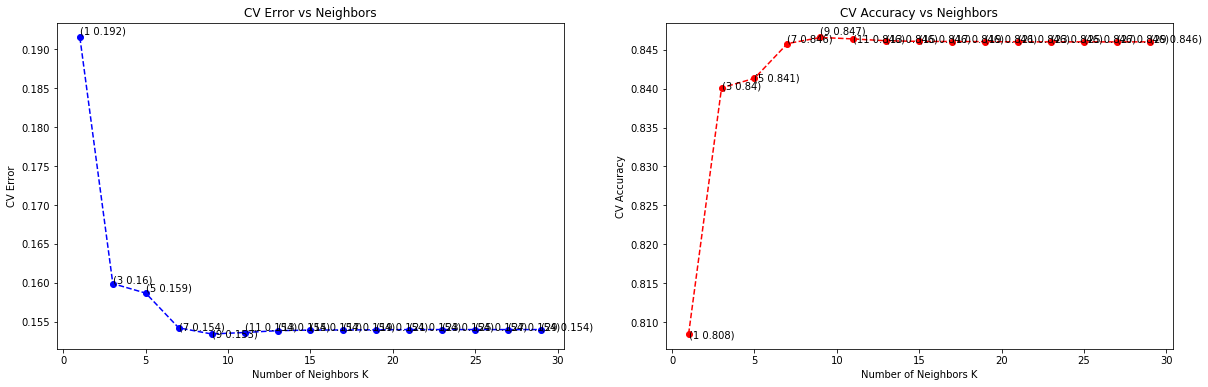


CV Error for each value of k:  [0.192 0.16  0.159 0.154 0.153 0.154 0.154 0.154 0.154 0.154 0.154 0.154
 0.154 0.154 0.154]

CV Accuracy for each value of k:  [0.808 0.84  0.841 0.846 0.847 0.846 0.846 0.846 0.846 0.846 0.846 0.846
 0.846 0.846 0.846]
CPU times: user 26min 37s, sys: 1min 44s, total: 28min 22s
Wall time: 28min 22s


In [30]:
%%time
if __name__ == "__main__":
    KNeighbors(X_train_tfidfbi_std, y_train, "brute",cr_val = 10)


Test Accuracy with 9 Neighbors: 82.553 %

Test Error : 0.174


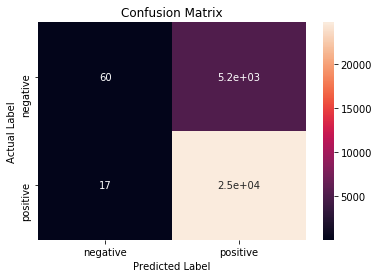

[[   60  5217]
 [   17 24706]]
CPU times: user 1min 46s, sys: 7.93 s, total: 1min 54s
Wall time: 1min 54s


In [31]:
%%time
if __name__ == "__main__":
    KNeighbors_Test(X_train_tfidfbi_std, X_test_tfidfbi_std, y_train, y_test, "brute", optimal_k = 9, batchwise_points = 15000)

#### [7.6.2] KNN Using Kd_Tree Algorithim :

<b>Reducing the dimensions(d = 50) using Truncated SVD and finding the optimal k using 10-fold cross validation. </b>

In [36]:
%%time
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=50,n_iter=5,random_state=0)
X_train_tfidfbi_kdtree = tsvd.fit_transform(X_train_tfidfbi)
X_test_tfidfbi_kdtree = tsvd.transform(X_test_tfidfbi)

CPU times: user 13.6 s, sys: 244 ms, total: 13.8 s
Wall time: 3.38 s


In [37]:
dumpfile(X_train_tfidfbi_kdtree,"X_train_tfidfbi_kdtree")
dumpfile(X_test_tfidfbi_kdtree,"X_test_tfidfbi_kdtree")

In [9]:
X_train_tfidfbi_kdtree = loadfile("X_train_tfidfbi_kdtree")
X_test_tfidfbi_kdtree = loadfile("X_test_tfidfbi_kdtree")

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_tfidfbi_kdtree_std = sc.fit_transform(X_train_tfidfbi_kdtree)

In [11]:
X_test_tfidfbi_kdtree_std = sc.transform(X_test_tfidfbi_kdtree)

In [12]:
print("Shape of Training Data: ",X_train_tfidfbi_kdtree_std.shape)
print("Shape of Test Data: ",X_test_tfidfbi_kdtree_std.shape)

Shape of Training Data:  (70000, 50)
Shape of Test Data:  (30000, 50)



Split 1 ---------->
Shape of Train Data:  (6370, 50)
Shape of CV Data:  (6363, 50)

Split 2 ---------->
Shape of Train Data:  (12733, 50)
Shape of CV Data:  (6363, 50)

Split 3 ---------->
Shape of Train Data:  (19096, 50)
Shape of CV Data:  (6363, 50)

Split 4 ---------->
Shape of Train Data:  (25459, 50)
Shape of CV Data:  (6363, 50)

Split 5 ---------->
Shape of Train Data:  (31822, 50)
Shape of CV Data:  (6363, 50)

Split 6 ---------->
Shape of Train Data:  (38185, 50)
Shape of CV Data:  (6363, 50)

Split 7 ---------->
Shape of Train Data:  (44548, 50)
Shape of CV Data:  (6363, 50)

Split 8 ---------->
Shape of Train Data:  (50911, 50)
Shape of CV Data:  (6363, 50)

Split 9 ---------->
Shape of Train Data:  (57274, 50)
Shape of CV Data:  (6363, 50)

Split 10 ---------->
Shape of Train Data:  (63637, 50)
Shape of CV Data:  (6363, 50)

The optimal number of neighbors:  17

CrossValidation Error: 0.138

CrossValidation Accuracy: 86.194 %


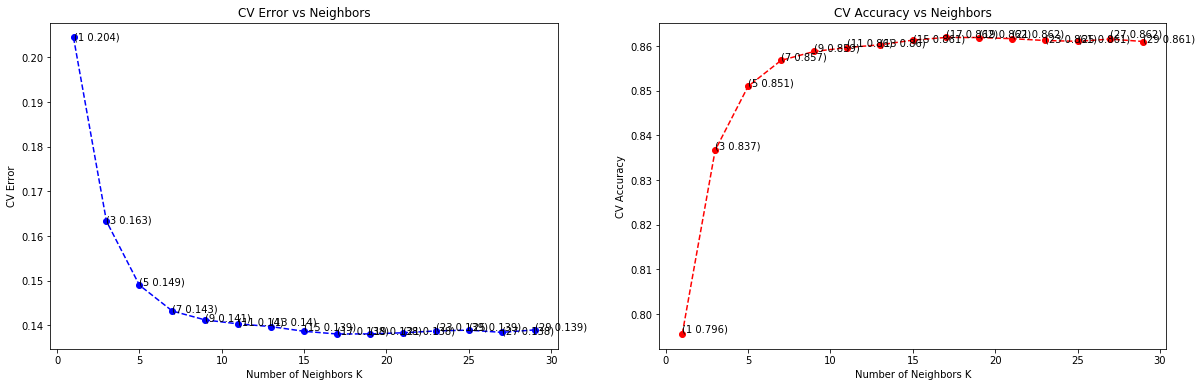


CV Error for each value of k:  [0.204 0.163 0.149 0.143 0.141 0.14  0.14  0.139 0.138 0.138 0.138 0.139
 0.139 0.138 0.139]

CV Accuracy for each value of k:  [0.796 0.837 0.851 0.857 0.859 0.86  0.86  0.861 0.862 0.862 0.862 0.861
 0.861 0.862 0.861]
CPU times: user 1h 45min 54s, sys: 240 ms, total: 1h 45min 55s
Wall time: 1h 45min 55s


In [ ]:
%%time
if __name__ == "__main__":
    KNeighbors(X_train_tfidfbi_kdtree_std, y_train, "kd_tree",cr_val = 10)

In [ ]:
%%time
if __name__ == "__main__":
    KNeighbors_Test(X_train_tfidfbi_kdtree_std, X_test_tfidfbi_kdtree_std, y_train, y_test, "kd_tree", optimal_k = 17, batchwise_points = 15000)

 

<b>Observations</b>:  

| KNN Algorithim | Optimal K | CV Error | Test Error | Test Accuracy(In %) |
| --- | --- | --- | --- | --- |
| Brute Force | 9 | 0.153 | 0.174 | 82.553 |
| Kd Tree | 17 | 0.138 | 0.15 | 84.97|

### [7.7] Average Word2Vec : <a name="avgw2v"></a>

<b>Training own Word2Vec model for train data using our own corpus: </b>

In [32]:
i=0
list_of_sent=[]
for sent in X:
    list_of_sent.append(sent.split())

In [33]:
print(X[0])
print("****************************************************************************")
print(list_of_sent[0])

bought apart infest fruit fli hour trap mani fli within day practic gone may not long term solut fli drive crazi consid buy one surfac sticki tri avoid touch
****************************************************************************
['bought', 'apart', 'infest', 'fruit', 'fli', 'hour', 'trap', 'mani', 'fli', 'within', 'day', 'practic', 'gone', 'may', 'not', 'long', 'term', 'solut', 'fli', 'drive', 'crazi', 'consid', 'buy', 'one', 'surfac', 'sticki', 'tri', 'avoid', 'touch']


In [34]:
## Word2Vec Model considering only those words that occur atleast 5 times in the corpus
min_count = 5
w2v_model = Word2Vec(list_of_sent, min_count = min_count, size = 50, workers = 4)
w2v_words = list(w2v_model.wv.vocab)

In [35]:
%%time
avgw2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent:
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgw2v_vectors.append(sent_vec)

CPU times: user 2min 31s, sys: 36 ms, total: 2min 31s
Wall time: 2min 31s


In [37]:
from sklearn.model_selection import train_test_split
X_train_avgw2v,X_test_avgw2v,y_train,y_test = train_test_split(avgw2v_vectors,y,test_size = 0.3,shuffle = False)

In [38]:
dumpfile(X_train_avgw2v,"X_train_avgw2v")
dumpfile(X_test_avgw2v,"X_test_avgw2v")

In [20]:
X_train_avgw2v = loadfile("X_train_avgw2v")
X_test_avgw2v = loadfile("X_test_avgw2v")

In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_avgw2v_std = sc.fit_transform(X_train_avgw2v)

In [22]:
X_test_avgw2v_std = sc.transform(X_test_avgw2v)

In [23]:
print("Shape of Training Data: ",X_train_avgw2v_std.shape)
print("Shape of Test Data: ",X_test_avgw2v_std.shape)

Shape of Training Data:  (70000, 50)
Shape of Test Data:  (30000, 50)


#### [7.7.1] KNN Using Brute Force Algorithim :


Split 1 ---------->
Shape of Train Data:  (6370, 50)
Shape of CV Data:  (6363, 50)

Split 2 ---------->
Shape of Train Data:  (12733, 50)
Shape of CV Data:  (6363, 50)

Split 3 ---------->
Shape of Train Data:  (19096, 50)
Shape of CV Data:  (6363, 50)

Split 4 ---------->
Shape of Train Data:  (25459, 50)
Shape of CV Data:  (6363, 50)

Split 5 ---------->
Shape of Train Data:  (31822, 50)
Shape of CV Data:  (6363, 50)

Split 6 ---------->
Shape of Train Data:  (38185, 50)
Shape of CV Data:  (6363, 50)

Split 7 ---------->
Shape of Train Data:  (44548, 50)
Shape of CV Data:  (6363, 50)

Split 8 ---------->
Shape of Train Data:  (50911, 50)
Shape of CV Data:  (6363, 50)

Split 9 ---------->
Shape of Train Data:  (57274, 50)
Shape of CV Data:  (6363, 50)

Split 10 ---------->
Shape of Train Data:  (63637, 50)
Shape of CV Data:  (6363, 50)

The optimal number of neighbors:  9

CrossValidation Error: 0.124

CrossValidation Accuracy: 87.633 %


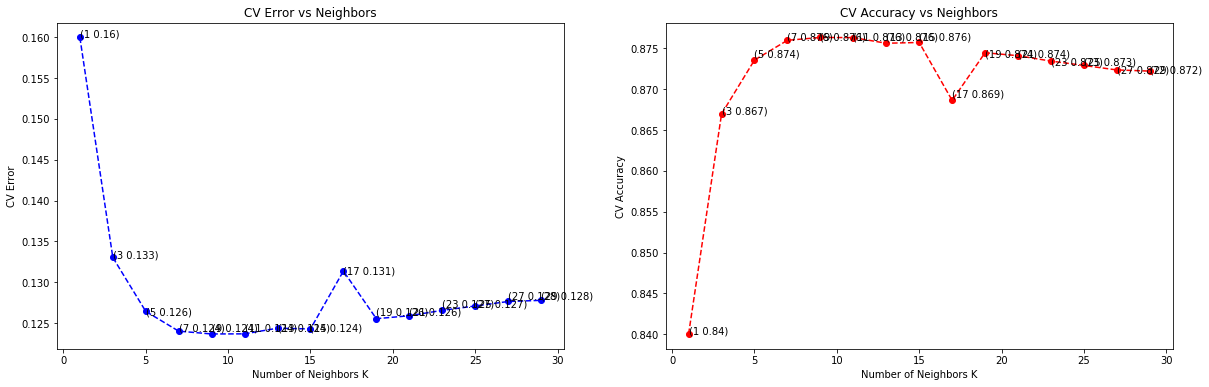


CV Error for each value of k:  [0.16  0.133 0.126 0.124 0.124 0.124 0.124 0.124 0.131 0.126 0.126 0.127
 0.127 0.128 0.128]

CV Accuracy for each value of k:  [0.84  0.867 0.874 0.876 0.876 0.876 0.876 0.876 0.869 0.874 0.874 0.873
 0.873 0.872 0.872]
CPU times: user 17min 48s, sys: 1min 6s, total: 18min 55s
Wall time: 10min 27s


In [43]:
%%time
if __name__ == "__main__":
    KNeighbors(X_train_avgw2v_std, y_train, "brute",cr_val = 10)


Test Accuracy with 9 Neighbors: 86.69 %

Test Error : 0.133


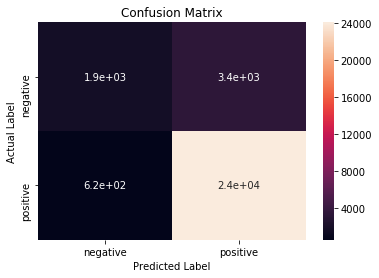

[[ 1902  3375]
 [  618 24105]]
CPU times: user 59.8 s, sys: 4.16 s, total: 1min 3s
Wall time: 37.2 s


In [45]:
%%time
if __name__ == "__main__":
    KNeighbors_Test(X_train_avgw2v_std, X_test_avgw2v_std, y_train, y_test, "brute",optimal_k = 9,batchwise_points = 15000)

#### [7.7.2] KNN Using Kd_Tree Algorithim :


Split 1 ---------->
Shape of Train Data:  (6370, 50)
Shape of CV Data:  (6363, 50)

Split 2 ---------->
Shape of Train Data:  (12733, 50)
Shape of CV Data:  (6363, 50)

Split 3 ---------->
Shape of Train Data:  (19096, 50)
Shape of CV Data:  (6363, 50)

Split 4 ---------->
Shape of Train Data:  (25459, 50)
Shape of CV Data:  (6363, 50)

Split 5 ---------->
Shape of Train Data:  (31822, 50)
Shape of CV Data:  (6363, 50)

Split 6 ---------->
Shape of Train Data:  (38185, 50)
Shape of CV Data:  (6363, 50)

Split 7 ---------->
Shape of Train Data:  (44548, 50)
Shape of CV Data:  (6363, 50)

Split 8 ---------->
Shape of Train Data:  (50911, 50)
Shape of CV Data:  (6363, 50)

Split 9 ---------->
Shape of Train Data:  (57274, 50)
Shape of CV Data:  (6363, 50)

Split 10 ---------->
Shape of Train Data:  (63637, 50)
Shape of CV Data:  (6363, 50)

The optimal number of neighbors:  9

CrossValidation Error: 0.124

CrossValidation Accuracy: 87.633 %


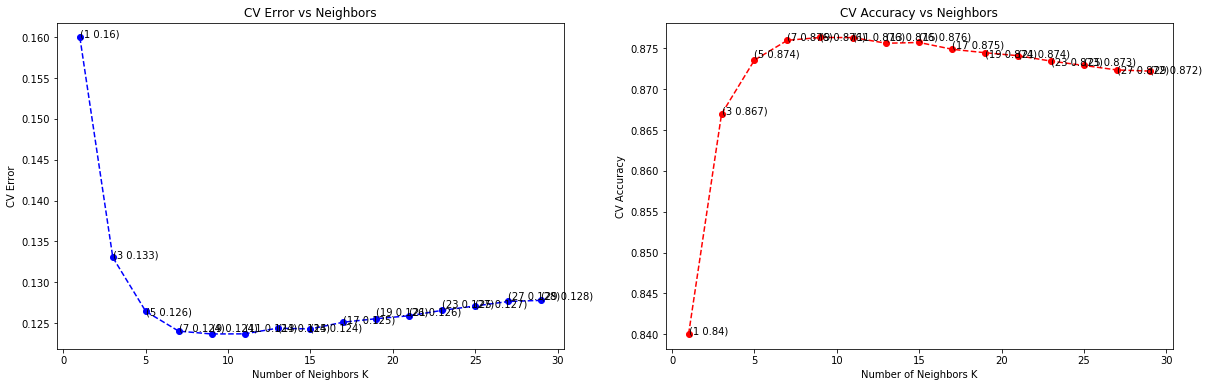


CV Error for each value of k:  [0.16  0.133 0.126 0.124 0.124 0.124 0.124 0.124 0.125 0.126 0.126 0.127
 0.127 0.128 0.128]

CV Accuracy for each value of k:  [0.84  0.867 0.874 0.876 0.876 0.876 0.876 0.876 0.875 0.874 0.874 0.873
 0.873 0.872 0.872]
CPU times: user 1h 45min 51s, sys: 64 ms, total: 1h 45min 51s
Wall time: 1h 45min 51s


In [ ]:
%%time
if __name__ == "__main__":
    KNeighbors(X_train_avgw2v_std, y_train, "kd_tree",cr_val = 10)


Test Accuracy with 9 Neighbors: 86.69 %

Test Error : 0.133


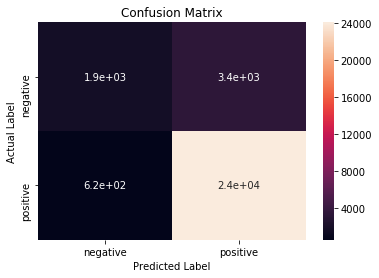

[[ 1902  3375]
 [  618 24105]]
CPU times: user 7min 35s, sys: 8 ms, total: 7min 35s
Wall time: 7min 35s


In [24]:
%%time
if __name__ == "__main__":
    KNeighbors_Test(X_train_avgw2v_std, X_test_avgw2v_std, y_train, y_test, "kd_tree",optimal_k = 9,batchwise_points = 15000)

 

<b>Observations</b>:  

| KNN Algorithim | Optimal K | CV Error | Test Error | Test Accuracy(In %) |
| --- | --- | --- | --- | --- |
| Brute Force | 9 | 0.124 | 0.133 | 86.69 |
| Kd Tree | 9 | 0.124 | 0.133 | 86.69|

### [7.8] TF-IDF Weighted Word2Vec : <a name="tfidfw2v"></a>

In [46]:
## Taking min_df = 0.0005 to ignore terms that appear in 
## less than 0.05% of the documents(do not occur too frequently
tfidf = TfidfVectorizer(min_df= 0.0005,ngram_range=(1,2))
tfidf_vectors = tfidf.fit_transform(X)

In [47]:
tfidf_feat = tfidf.get_feature_names()

In [48]:
%%time
tfidfw2v_vectors = [];
row=0;
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = tfidf_vectors[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2v_vectors.append(sent_vec)
    row += 1

CPU times: user 12min 17s, sys: 8 ms, total: 12min 17s
Wall time: 12min 17s


In [49]:
#Converting list of list to numpy array
tfidfw2v_vectors=np.array(tfidfw2v_vectors)

In [50]:
from sklearn.model_selection import train_test_split
X_train_tfidfw2v,X_test_tfidfw2v,y_train,y_test = train_test_split(tfidfw2v_vectors,y,test_size = 0.3,shuffle = False)

In [51]:
dumpfile(X_train_tfidfw2v,"X_train_tfidfw2v")
dumpfile(X_test_tfidfw2v,"X_test_tfidfw2v")

In [25]:
X_train_tfidfw2v = loadfile("X_train_tfidfw2v")
X_test_tfidfw2v = loadfile("X_test_tfidfw2v")

In [26]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_tfidfw2v_std = sc.fit_transform(X_train_tfidfw2v)

In [27]:
X_test_tfidfw2v_std = sc.transform(X_test_tfidfw2v)

In [28]:
print("Shape of Training Data: ",X_train_tfidfw2v_std.shape)
print("Shape of Test Data: ",X_test_tfidfw2v_std.shape)

Shape of Training Data:  (70000, 50)
Shape of Test Data:  (30000, 50)


#### [7.8.1] KNN Using BruteForce Algorithim :


Split 1 ---------->
Shape of Train Data:  (6370, 50)
Shape of CV Data:  (6363, 50)

Split 2 ---------->
Shape of Train Data:  (12733, 50)
Shape of CV Data:  (6363, 50)

Split 3 ---------->
Shape of Train Data:  (19096, 50)
Shape of CV Data:  (6363, 50)

Split 4 ---------->
Shape of Train Data:  (25459, 50)
Shape of CV Data:  (6363, 50)

Split 5 ---------->
Shape of Train Data:  (31822, 50)
Shape of CV Data:  (6363, 50)

Split 6 ---------->
Shape of Train Data:  (38185, 50)
Shape of CV Data:  (6363, 50)

Split 7 ---------->
Shape of Train Data:  (44548, 50)
Shape of CV Data:  (6363, 50)

Split 8 ---------->
Shape of Train Data:  (50911, 50)
Shape of CV Data:  (6363, 50)

Split 9 ---------->
Shape of Train Data:  (57274, 50)
Shape of CV Data:  (6363, 50)

Split 10 ---------->
Shape of Train Data:  (63637, 50)
Shape of CV Data:  (6363, 50)

The optimal number of neighbors:  11

CrossValidation Error: 0.132

CrossValidation Accuracy: 86.788 %


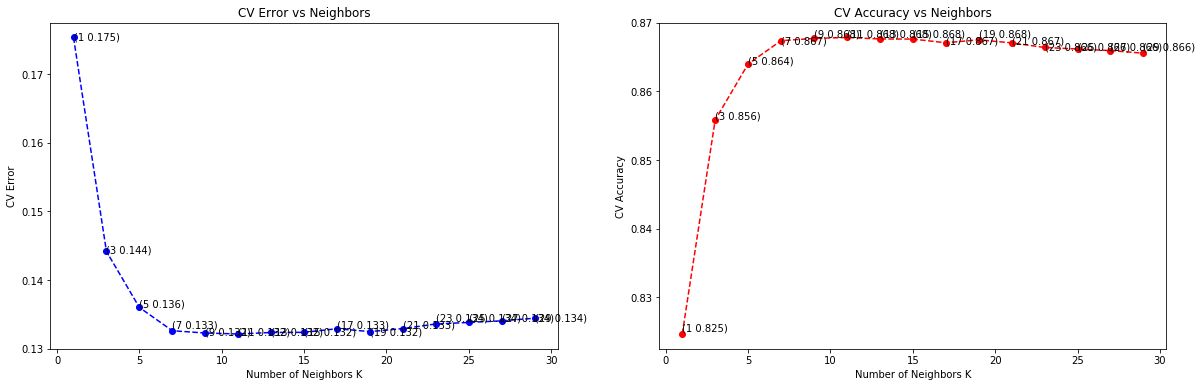


CV Error for each value of k:  [0.175 0.144 0.136 0.133 0.132 0.132 0.132 0.132 0.133 0.132 0.133 0.134
 0.134 0.134 0.134]

CV Accuracy for each value of k:  [0.825 0.856 0.864 0.867 0.868 0.868 0.868 0.868 0.867 0.868 0.867 0.866
 0.866 0.866 0.866]
CPU times: user 17min 48s, sys: 1min 6s, total: 18min 54s
Wall time: 10min 24s


In [56]:
%%time
if __name__ == "__main__":
    KNeighbors(X_train_tfidfw2v_std, y_train, "brute",cr_val=10)


Test Accuracy with 11 Neighbors: 85.607 %

Test Error : 0.144


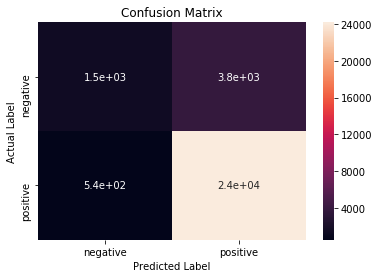

[[ 1501  3776]
 [  542 24181]]
CPU times: user 1min 3s, sys: 5.23 s, total: 1min 9s
Wall time: 41.7 s


In [57]:
%%time
if __name__ == "__main__":
    KNeighbors_Test(X_train_tfidfw2v_std, X_test_tfidfw2v_std, y_train, y_test, "brute",optimal_k = 11,batchwise_points = 15000)

#### [7.8.2] KNN Using Kd_Tree Algorithim :


Split 1 ---------->
Shape of Train Data:  (6370, 50)
Shape of CV Data:  (6363, 50)

Split 2 ---------->
Shape of Train Data:  (12733, 50)
Shape of CV Data:  (6363, 50)

Split 3 ---------->
Shape of Train Data:  (19096, 50)
Shape of CV Data:  (6363, 50)

Split 4 ---------->
Shape of Train Data:  (25459, 50)
Shape of CV Data:  (6363, 50)

Split 5 ---------->
Shape of Train Data:  (31822, 50)
Shape of CV Data:  (6363, 50)

Split 6 ---------->
Shape of Train Data:  (38185, 50)
Shape of CV Data:  (6363, 50)

Split 7 ---------->
Shape of Train Data:  (44548, 50)
Shape of CV Data:  (6363, 50)

Split 8 ---------->
Shape of Train Data:  (50911, 50)
Shape of CV Data:  (6363, 50)

Split 9 ---------->
Shape of Train Data:  (57274, 50)
Shape of CV Data:  (6363, 50)

Split 10 ---------->
Shape of Train Data:  (63637, 50)
Shape of CV Data:  (6363, 50)

The optimal number of neighbors:  11

CrossValidation Error: 0.132

CrossValidation Accuracy: 86.788 %


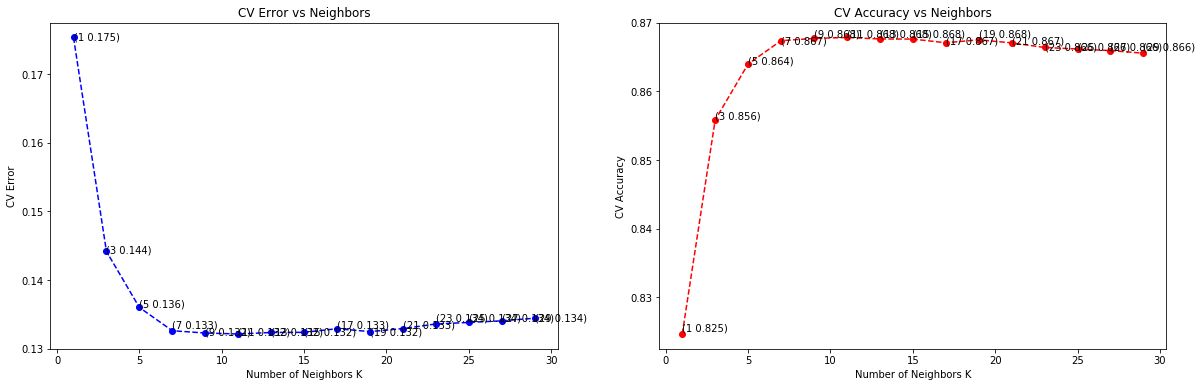


CV Error for each value of k:  [0.175 0.144 0.136 0.133 0.132 0.132 0.132 0.132 0.133 0.132 0.133 0.134
 0.134 0.134 0.134]

CV Accuracy for each value of k:  [0.825 0.856 0.864 0.867 0.868 0.868 0.868 0.868 0.867 0.868 0.867 0.866
 0.866 0.866 0.866]
CPU times: user 1h 34min 27s, sys: 68 ms, total: 1h 34min 27s
Wall time: 1h 34min 27s


In [29]:
%%time
if __name__ == "__main__":
    KNeighbors(X_train_tfidfw2v_std, y_train, "kd_tree",cr_val=10)


Test Accuracy with 11 Neighbors: 85.607 %

Test Error : 0.144


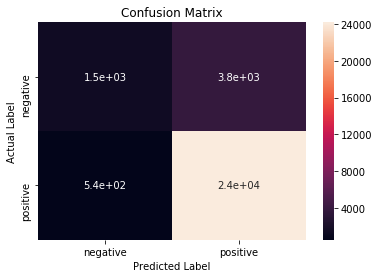

[[ 1501  3776]
 [  542 24181]]
CPU times: user 8min, sys: 16 ms, total: 8min
Wall time: 8min


In [30]:
%%time
if __name__ == "__main__":
    KNeighbors_Test(X_train_tfidfw2v_std, X_test_tfidfw2v_std, y_train, y_test, "kd_tree",optimal_k = 11,batchwise_points = 15000)

 

<b>Observations</b>:  

| KNN Algorithim | Optimal K | CV Error | Test Error | Test Accuracy(In %) |
| --- | --- | --- | --- | --- |
| Brute Force | 11 | 0.132 | 0.144 | 85.607 |
| Kd Tree | 11 | 0.132 | 0.144 | 85.607|

## [8] Conclusion : <a name="conclusion"></a>


| Featurization Model | Brute Force |  |  | Kd Tree |  |  |
| --- | --- | --- | --- | --- | --- | --- |
|  | <b>Optimal K</b>| <b>Accuracy</b> | <b>Run Time</b> | <b>Optimal K</b> | <b>Accuracy</b> | <b>Run Time</b> |
| <b>BOW(unigram)</b> | 7 | 83.347 % | ~2 minutes  | 11 | 84.733 % | ~8 minutes  |
| <b>BOW(bigram)</b> | 9 | 82.907 % | ~2 minutes  | 17 | 83.917 % | ~8 minutes  |
| <b>TF-IDF(unigram)</b> | 7 | 82.753 % | ~2 minutes  | 21 | 84.79 % | ~8 minutes  |
| <b>TF-IDF(bigram)</b> | 9 | 82.553 % | ~2 minutes  | 17 | 84.97 % | ~8 minutes  |
| <b>Average Word2Vec</b> | 9 | 86.69 % |  ~40 seconds | 9 | 86.69 % | ~8 minutes  |
| <b>TFIDF Weighted Word2Vec</b> | 11 | 85.607 % | ~40 seconds  | 11 | 85.607 % |  ~8 minutes |

<br>
<b>1 - </b>Using <b>Average Word2Vec</b> method, KNN algorithim gives best accuracy of <b>86.69 %</b> taking <b>9 Nearest Neigbors</b> with both brute force and kd tree implementation.

<b>2 - </b> I also observed that <b>most of the negative reviews are misclassified</b>. It could be due to the impact of positive reviews being a majority class holding 85% of total data points(imbalanced dataset).

<b>3 - </b> In all the models, <b>Run Time complexity with kd tree is very high</b> as compared to brute force , when predciting on test data(unseen query points). 

<b>4 - </b>It may be aslo concluded that though kd tree reduces the time complexity,but it fails here as dimensions are not small and the distribution of data is not uniform.